# Trabalho 1 — INF-0618 Deep Learning   


Para este trabalho, utilizaremos a base de dados DermaMNIST, composta de 10.015 imagens (7.007 de treino, 1.003 de validação e 2.005 de teste) subdivididas em 7 classes.

Cada amostra do dado está associada a exatamente um dos seguintes rótulos:
- *actinic keratoses and intraepithelial carcinoma* (0)
- *basal cell carcinoma* (1)
- *benign keratosis-like lesions* (2)
- *dermatofibroma* (3)
- *melanoma* (4)
- *melanocytic nevi* (5)
- *vascular lesions* (6)

<img src="https://medmnist.com/assets/v2/imgs/DermaMNIST.jpg" />

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## *Download* dos dados

Utilizaremos da bibilioteca curl para baixar a base de dados DermaMNIST. Usaremos o comando da seguinte forma

```
curl -o nome_do_arquivo link_para_download
```


In [2]:
!curl -o dermamnist.npz https://zenodo.org/records/10519652/files/dermamnist.npz?download=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M  100 18.8M    0     0  9462k      0  0:00:02  0:00:02 --:--:-- 9465k


## Carregando os dados

In [3]:
import numpy as np

In [4]:
# Carrega a base de dados
dermamnist = np.load("dermamnist.npz") # O arquivo chama-se dermamnist.npz (definido no curl)

# Separa em conjuntos de treino, validacao e teste
x_train = dermamnist["train_images"]
y_train = dermamnist["train_labels"]

x_val = dermamnist["val_images"]
y_val = dermamnist["val_labels"]

x_test = dermamnist["test_images"]
y_test = dermamnist["test_labels"]

In [5]:
# para visualizar os dados, utilizaremos a biblioteca matplotlib
from matplotlib import pyplot as plt

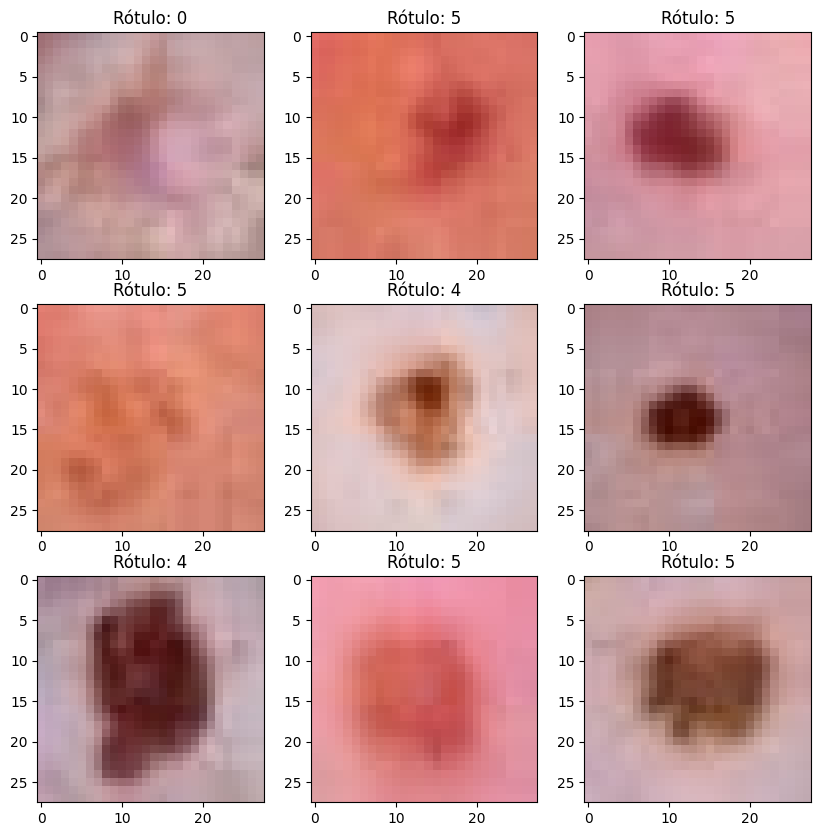

In [6]:
fig, ax = plt.subplots(figsize=(10,10), ncols=3, nrows=3)
sample = 0
for i in range(3):
    for j in range(3):
        imagem = x_train[sample]
        ax[i][j].imshow(imagem)
        rotulo = y_train[sample][0]
        ax[i][j].title.set_text(f"Rótulo: {rotulo}")
        sample += 1

## Preparação dos dados

In [7]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.7 MB/s eta 0:00:00


In [25]:
import os

import visualkeras

import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [9]:
x_train.shape

(7007, 28, 28, 3)

In [10]:
y_train.shape

(7007, 1)

In [9]:
# Ajustando o formato da variavel y para one-hot encoding
n_classes = 7

y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_ohe = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_test_ohe = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

In [20]:
# Checando a distribuicao das classes
unique, counts = np.unique(y_train, return_counts=True)
print( "Treino:", dict(zip(unique, counts)) )

Treino: {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [21]:
y_train.reshape(-1).shape

(7007,)

In [22]:
# Nossos dados de treinamento estao desbalanceados
# Vamos testar o desenvolvimento a seguir utilizando o balanceamento das classes via pesos
# (Caso necessario mudaremos a estrategia posteriormente)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(y_train.reshape(-1)),
                                     y=y_train.reshape(-1))
train_class_weights = dict(enumerate(class_weights))

train_class_weights

{0: 4.390350877192983,
 1: 2.788300835654596,
 2: 1.3016905071521456,
 3: 12.5125,
 4: 1.2849807445442876,
 5: 0.21329639889196675,
 6: 10.11111111111111}

In [12]:
# Normalizando os dados
x_train_norm = x_train / 255.0
x_val_norm = x_val / 255.0
x_test_norm = x_test / 255.0

In [24]:
x_train_norm[0]

array([[[0.61960784, 0.43529412, 0.45882353],
        [0.63137255, 0.45490196, 0.4745098 ],
        [0.64313725, 0.4745098 , 0.50980392],
        ...,
        [0.74117647, 0.62745098, 0.64313725],
        [0.73333333, 0.61960784, 0.62745098],
        [0.72941176, 0.61568627, 0.62352941]],

       [[0.62745098, 0.44313725, 0.46666667],
        [0.64705882, 0.47058824, 0.49019608],
        [0.66666667, 0.50588235, 0.5372549 ],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.74117647, 0.62745098, 0.63529412],
        [0.7372549 , 0.62352941, 0.63137255]],

       [[0.64313725, 0.46666667, 0.48627451],
        [0.66666667, 0.50196078, 0.51764706],
        [0.69411765, 0.5372549 , 0.56862745],
        ...,
        [0.74901961, 0.63529412, 0.65098039],
        [0.7372549 , 0.63529412, 0.64705882],
        [0.73333333, 0.63137255, 0.64313725]],

       ...,

       [[0.6745098 , 0.55686275, 0.58823529],
        [0.69019608, 0.57647059, 0.59607843],
        [0.71372549, 0

## Modelo baseline

In [25]:
x_train_norm.shape[1:]

(28, 28, 3)

In [13]:
INPUT_SHAPE = x_train_norm.shape[1:]

### Training the model WITH class weights

In [49]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           data_format=None,
                           dilation_rate=(1, 1),
                           groups=1,
                           activation="relu",
                           use_bias=True,
                           kernel_initializer="glorot_uniform",
                           bias_initializer="zeros",
                           kernel_regularizer=None,
                           bias_regularizer=None,
                           activity_regularizer=None,
                           kernel_constraint=None,
                           bias_constraint=None,
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 12)        336       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2028)              0         
                                                                 
 dense_2 (Dense)             (None, 7)                 14203     
                                                                 
Total params: 14539 (56.79 KB)
Trainable params: 14539 (56.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


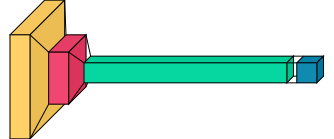

In [50]:
visualkeras.layered_view(baseline_model)

In [51]:
# Compilando o modelo baseline
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

In [52]:
model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_name = "baseline_with_class_weights_model.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
baseline_model.fit( x_train_norm, y_train_ohe,
                    epochs=500,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    class_weight=train_class_weights,
                    callbacks=[# early_stopping,
                               model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 1s 8ms/step - loss: 1.9669 - accuracy: 0.0280 - val_loss: 1.9355 - val_accuracy: 0.1306
Epoch 2/500
45/55 [=======================>......] - ETA: 0s - loss: 1.9790 - accuracy: 0.0559

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 4ms/step - loss: 1.9506 - accuracy: 0.0558 - val_loss: 1.9508 - val_accuracy: 0.0818
Epoch 3/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9458 - accuracy: 0.0501 - val_loss: 1.9511 - val_accuracy: 0.0847
Epoch 4/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9430 - accuracy: 0.0758 - val_loss: 1.9695 - val_accuracy: 0.0499
Epoch 5/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9395 - accuracy: 0.0484 - val_loss: 1.9593 - val_accuracy: 0.0788
Epoch 6/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9373 - accuracy: 0.0632 - val_loss: 1.9468 - val_accuracy: 0.0937
Epoch 7/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9341 - accuracy: 0.0959 - val_loss: 1.9480 - val_accuracy: 0.0917
Epoch 8/500
55/55 [==============================] - 0s 4ms/step - loss: 1.9308 - accuracy: 0.1093 - val_loss: 1.9457 - val_accuracy: 0.0648
Epoch 9/500
55/55 [======

In [14]:
def plot_loss_values(history):
    plt.figure(figsize=(10, 5))

    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")

    plt.legend()
    plt.show()

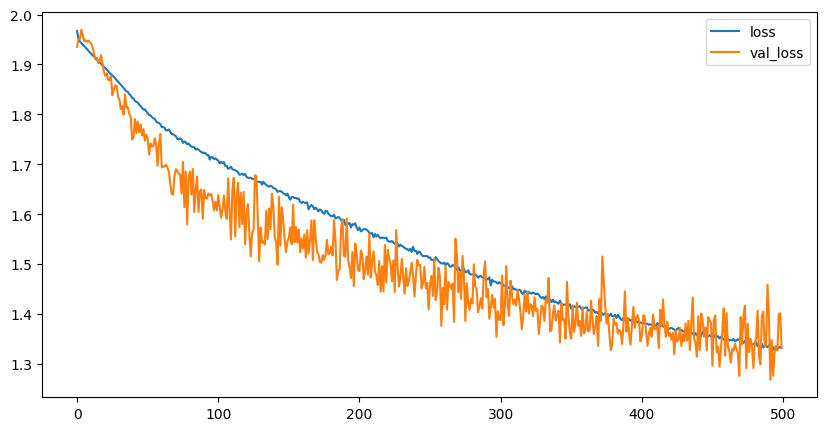

In [54]:
plot_loss_values(baseline_model.history.history)

In [15]:
def print_accuracy_and_loss(model, name, description, data_type,
                            xval=x_val_norm, yval=y_val_ohe): # x_val_norm, y_val_ohe

    loss, acc = model.evaluate(xval, yval)

    validation_results = {
        "model": {
            "data": data_type,
            "name": name,
            "description": description,
            "loss": loss,
            "accuracy": acc
        }
    }

    print(validation_results)

In [81]:
path_full = os.path.join(model_path, "baseline_with_class_weights_model.h5")
baseline_model = tf.keras.models.load_model(path_full) # Loading the best model trained

print_accuracy_and_loss(baseline_model,
                        "baseline_with_class_weights",
                        "Modelo baseline com pesos de classes ajustados",
                        "validation")

32/32 [==============================] - 0s 3ms/step - loss: 1.2678 - accuracy: 0.5125
{'model': {'data': 'validation', 'name': 'baseline_with_class_weights', 'description': 'Modelo baseline com pesos de classes ajustados', 'loss': 1.2677539587020874, 'accuracy': 0.5124626159667969}}


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


### Training the model WITHOUT class weights

In [62]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           data_format=None,
                           dilation_rate=(1, 1),
                           groups=1,
                           activation="relu",
                           use_bias=True,
                           kernel_initializer="glorot_uniform",
                           bias_initializer="zeros",
                           kernel_regularizer=None,
                           bias_regularizer=None,
                           activity_regularizer=None,
                           kernel_constraint=None,
                           bias_constraint=None,
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

# Compilando o modelo baseline
baseline_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                       metrics=["accuracy"])

model_name = "baseline_model.h5"
model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
baseline_model.fit( x_train_norm, y_train_ohe,
                    epochs=500,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    # class_weight=train_class_weights,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 1s 11ms/step - loss: 1.4100 - accuracy: 0.6698 - val_loss: 1.2145 - val_accuracy: 0.6690
Epoch 2/500
23/55 [===========>..................] - ETA: 0s - loss: 1.2028 - accuracy: 0.6692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 7ms/step - loss: 1.1913 - accuracy: 0.6698 - val_loss: 1.1708 - val_accuracy: 0.6690
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1623 - accuracy: 0.6698 - val_loss: 1.1514 - val_accuracy: 0.6690
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1469 - accuracy: 0.6698 - val_loss: 1.1406 - val_accuracy: 0.6690
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1380 - accuracy: 0.6698 - val_loss: 1.1341 - val_accuracy: 0.6690
Epoch 6/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1320 - accuracy: 0.6698 - val_loss: 1.1290 - val_accuracy: 0.6690
Epoch 7/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1270 - accuracy: 0.6698 - val_loss: 1.1246 - val_accuracy: 0.6690
Epoch 8/500
55/55 [==============================] - 0s 5ms/step - loss: 1.1224 - accuracy: 0.6698 - val_loss: 1.1207 - val_accuracy: 0.6690
Epoch 9/500
55/55 [======

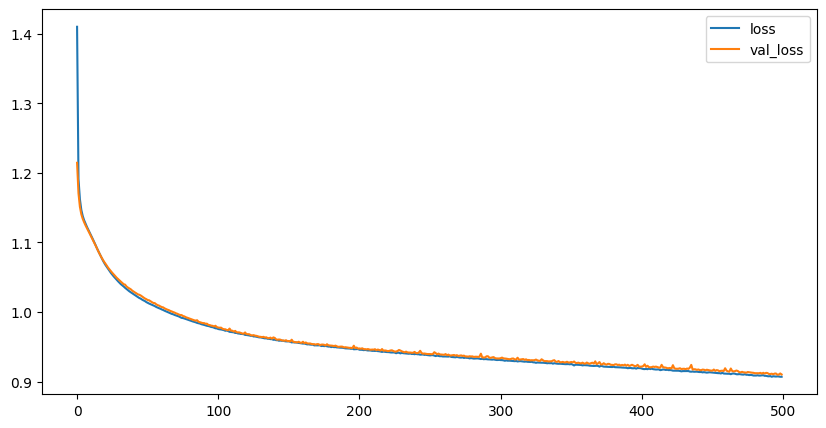

In [63]:
plot_loss_values(baseline_model.history.history)

In [65]:
model_path_full

'/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/baseline_model.h5'

In [83]:
path_full = os.path.join(model_path, "baseline_model.h5")
baseline_model = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(baseline_model,
                        "baseline_without_class_weights",
                        "Modelo baseline SEM pesos de classes ajustados",
                        "validation")

32/32 [==============================] - 0s 4ms/step - loss: 0.9100 - accuracy: 0.6810
{'model': {'data': 'validation', 'name': 'baseline_without_class_weights', 'description': 'Modelo baseline SEM pesos de classes ajustados', 'loss': 0.9100164771080017, 'accuracy': 0.6809571385383606}}


### Exploring variations of the baseline model

In [67]:
INPUT_SHAPE

(28, 28, 3)

#### Variation 1 (Best baseline model)

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu",
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(2, 2),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=28,
                          activation="relu"),

    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
    ])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 12)        336       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 12)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 13, 13, 12)        48        
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 6)         294       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 6)           0         
 g2D)                                                            
                                                      

In [69]:
model.compile(  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [70]:
model_path

'/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/'

In [71]:
model_name = "baseline_model_variation_N1.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
model.fit(          x_train_norm, y_train_ohe,
                    epochs=500,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 3s 17ms/step - loss: 1.6298 - accuracy: 0.4243 - val_loss: 1.8245 - val_accuracy: 0.4716
Epoch 2/500
20/55 [=========>....................] - ETA: 0s - loss: 1.3603 - accuracy: 0.5844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 8ms/step - loss: 1.2999 - accuracy: 0.6037 - val_loss: 1.7767 - val_accuracy: 0.4935
Epoch 3/500
55/55 [==============================] - 0s 9ms/step - loss: 1.2000 - accuracy: 0.6391 - val_loss: 1.6685 - val_accuracy: 0.5434
Epoch 4/500
55/55 [==============================] - 1s 9ms/step - loss: 1.1412 - accuracy: 0.6523 - val_loss: 1.5613 - val_accuracy: 0.6142
Epoch 5/500
55/55 [==============================] - 0s 6ms/step - loss: 1.1010 - accuracy: 0.6583 - val_loss: 1.4576 - val_accuracy: 0.6321
Epoch 6/500
55/55 [==============================] - 0s 7ms/step - loss: 1.0728 - accuracy: 0.6632 - val_loss: 1.3735 - val_accuracy: 0.6321
Epoch 7/500
55/55 [==============================] - 0s 6ms/step - loss: 1.0497 - accuracy: 0.6665 - val_loss: 1.2672 - val_accuracy: 0.6630
Epoch 8/500
55/55 [==============================] - 0s 6ms/step - loss: 1.0305 - accuracy: 0.6699 - val_loss: 1.1818 - val_accuracy: 0.6680
Epoch 9/500
55/55 [======

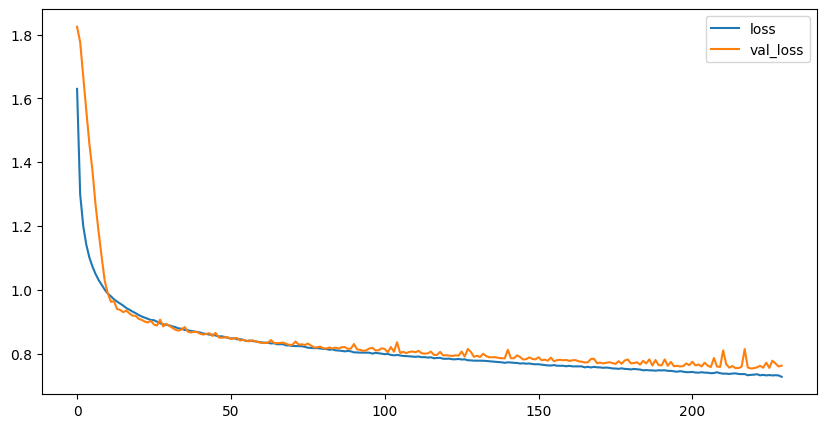

In [72]:
plot_loss_values(model.history.history)

In [84]:
path_full = os.path.join(model_path, "baseline_model_variation_N1.h5")
model_N1 = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(model_N1,
                        "baseline_variation_N1",
                        "Primeira variacao do modelo baseline",
                        "validation")

14/32 [============>.................] - ETA: 0s - loss: 0.7521 - accuracy: 0.7277

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 0s 4ms/step - loss: 0.7531 - accuracy: 0.7168
{'model': {'data': 'validation', 'name': 'baseline_variation_N1', 'description': 'Primeira variacao do modelo baseline', 'loss': 0.7530725002288818, 'accuracy': 0.7168494462966919}}


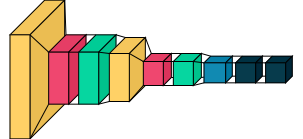

In [85]:
visualkeras.layered_view(model_N1)

#### Variation 2

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=12,
                           kernel_size=(3, 3),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu",
                           input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(2, 2),
                           strides=(1, 1),
                           padding="valid",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                              strides=None,
                              padding="valid"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=28,
                          activation="relu"),
    tf.keras.layers.Dropout(rate=0.25), # New
    tf.keras.layers.Dense(units=28,
                          activation="relu"),
    tf.keras.layers.Dropout(rate=0.25), # New

    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
    ])

model.compile(  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])

model_name = "baseline_model_variation_N2.h5"

model_path_full = os.path.join(model_path, model_name)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
model.fit(          x_train_norm, y_train_ohe,
                    epochs=500,
                    batch_size=128,
                    validation_data=(x_val_norm, y_val_ohe),
                    verbose=1,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
55/55 [==============================] - 3s 11ms/step - loss: 1.7111 - accuracy: 0.3509 - val_loss: 1.8607 - val_accuracy: 0.2881
Epoch 2/500
23/55 [===========>..................] - ETA: 0s - loss: 1.5331 - accuracy: 0.4626

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 0s 7ms/step - loss: 1.5100 - accuracy: 0.4844 - val_loss: 1.7164 - val_accuracy: 0.5952
Epoch 3/500
55/55 [==============================] - 0s 6ms/step - loss: 1.4049 - accuracy: 0.5463 - val_loss: 1.5468 - val_accuracy: 0.6510
Epoch 4/500
55/55 [==============================] - 0s 6ms/step - loss: 1.3393 - accuracy: 0.5887 - val_loss: 1.4190 - val_accuracy: 0.6610
Epoch 5/500
55/55 [==============================] - 0s 7ms/step - loss: 1.3001 - accuracy: 0.5984 - val_loss: 1.3133 - val_accuracy: 0.6670
Epoch 6/500
55/55 [==============================] - 0s 7ms/step - loss: 1.2506 - accuracy: 0.6150 - val_loss: 1.2345 - val_accuracy: 0.6660
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 1.2250 - accuracy: 0.6269 - val_loss: 1.1814 - val_accuracy: 0.6680
Epoch 8/500
55/55 [==============================] - 1s 11ms/step - loss: 1.2062 - accuracy: 0.6258 - val_loss: 1.1499 - val_accuracy: 0.6670
Epoch 9/500
55/55 [=====

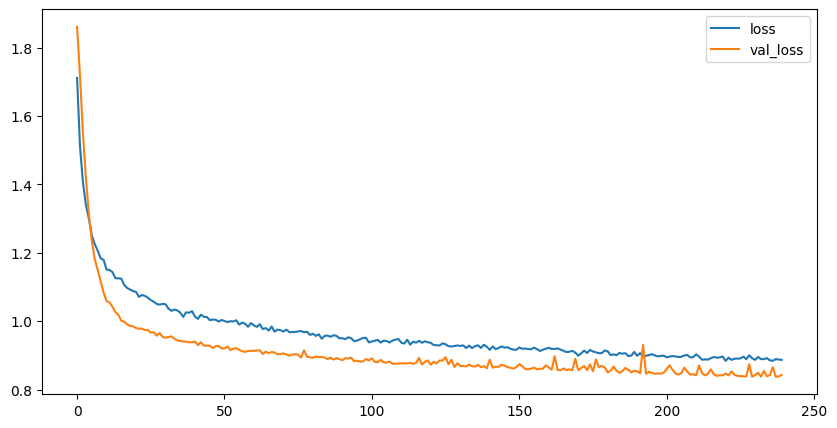

In [78]:
plot_loss_values(model.history.history)

In [86]:
path_full = os.path.join(model_path, "baseline_model_variation_N2.h5")
model_N2 = tf.keras.models.load_model(path_full)

print_accuracy_and_loss(model_N2,
                        "baseline_variation_N2",
                        "Segunda variacao do modelo baseline",
                        "validation")

# Por enquanto o melhor modelo foi a variação N1 do modelo baseline, com os seguintes resultados:
# {
#     'model': {'data': 'validation',
#               'name': 'baseline_variation_N1',
#               'description': 'Primeira variacao do modelo baseline',
#               'loss': 0.7530725002288818,
#               'accuracy': 0.7168494462966919}
#  }

32/32 [==============================] - 0s 3ms/step - loss: 0.8375 - accuracy: 0.6770
{'model': {'data': 'validation', 'name': 'baseline_variation_N2', 'description': 'Segunda variacao do modelo baseline', 'loss': 0.8375021815299988, 'accuracy': 0.6769691109657288}}


## Transfer-learning com fine-tuning da rede (Congelamento das camadas e adição de camada de saída)

In [131]:
pre_trained_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                            include_top=False,
                                                            input_shape=(75, 75, 3))

for layer in pre_trained_model.layers:
    layer.trainable = False

In [136]:
adapted_inception_model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16,
                          activation="relu"),
    tf.keras.layers.Dense(units=n_classes,
                          activation="softmax")
])

adapted_inception_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1, 1, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_7  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_8 (Flatten)         (None, 1536)              0         
                                                                 
 dense_16 (Dense)            (None, 16)                24592     
                                                                 
 dense_17 (Dense)            (None, 7)                 119       
                                                                 
Total params: 54361447 (207.37 MB)
Trainable params: 

In [91]:
# pre_trained_model.summary()

# Total params: 54336736 (207.28 MB)
# Trainable params: 54276192 (207.05 MB)
# Non-trainable params: 60544 (236.50 KB)_________________________________

In [16]:
!pip install scikit-image

In [17]:
from skimage.transform import resize

In [18]:
# Redimensionando as imagens para estarem no mesmo formato que a rede base usa
new_shape = (75, 75, 3)

def resize_images(images, new_shape=new_shape):

    resized_images = np.empty(shape=(images.shape[0],) + new_shape)
    for idx in range(images.shape[0]):
        resized_images[idx] = resize(images[idx], new_shape)

    print( images.shape, resized_images.shape )

    return resized_images

In [19]:
x_train_resized = resize_images(x_train)
x_val_resized = resize_images(x_val)
x_test_resized = resize_images(x_test)

(7007, 28, 28, 3) (7007, 75, 75, 3)
(1003, 28, 28, 3) (1003, 75, 75, 3)
(2005, 28, 28, 3) (2005, 75, 75, 3)


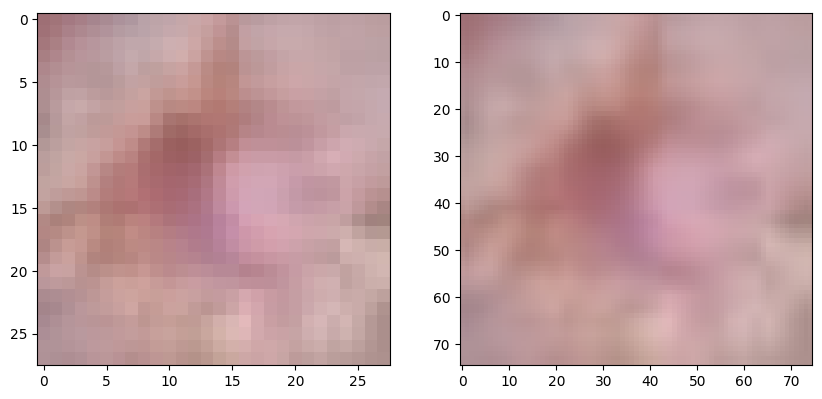

In [120]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_train[0])
ax[1].imshow(x_train_resized[0])

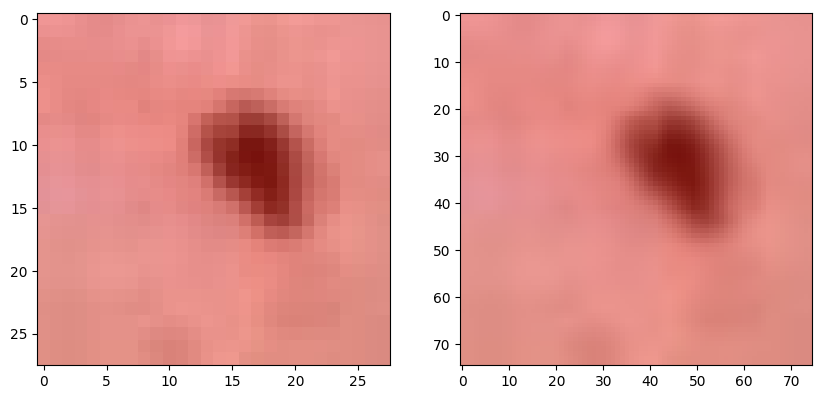

In [121]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_val[0])
ax[1].imshow(x_val_resized[0])

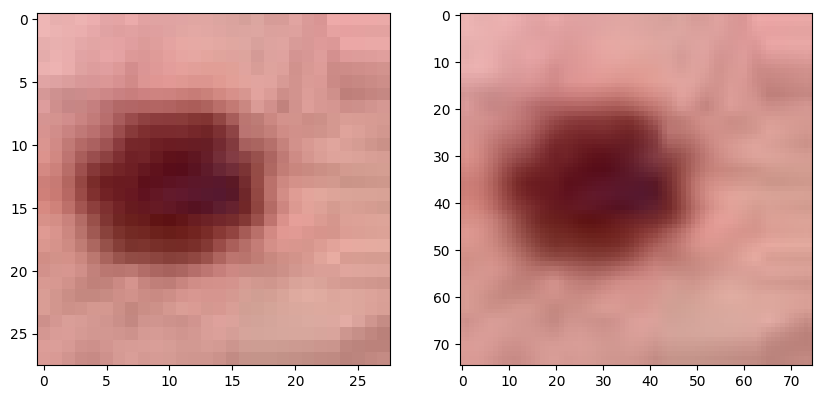

In [122]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(x_test[0])
ax[1].imshow(x_test_resized[0])

In [20]:
datagen_inception = tf.keras.preprocessing.image.ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
)

In [138]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.001)

# Batches de treino e validação
train_batches = datagen_inception.flow(x_train_resized, y_train_ohe, shuffle=True, batch_size=128)
val_batches = datagen_inception.flow(x_val_resized, y_val_ohe, shuffle=False, batch_size=128)

adapted_inception_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [127]:
next(train_batches)[0].shape

(128, 75, 75, 3)

In [21]:
model_path = "/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/"
model_name = "adapted_inception_model_finetunning.h5"
model_path_full = os.path.join(model_path, model_name)

In [139]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path_full,
                                                      monitor="val_loss",
                                                      save_best_only=True)
adapted_inception_model.fit(train_batches,
                            epochs=30,
                            validation_data=val_batches,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
55/55 [==============================] - 36s 451ms/step - loss: 1.8709 - accuracy: 0.3257 - val_loss: 1.7383 - val_accuracy: 0.6690
Epoch 2/30
55/55 [==============================] - 28s 522ms/step - loss: 1.5550 - accuracy: 0.6698 - val_loss: 1.3490 - val_accuracy: 0.6690
Epoch 3/30
55/55 [==============================] - 31s 569ms/step - loss: 1.2649 - accuracy: 0.6698 - val_loss: 1.2213 - val_accuracy: 0.6690
Epoch 4/30
55/55 [==============================] - 27s 489ms/step - loss: 1.1995 - accuracy: 0.6698 - val_loss: 1.1828 - val_accuracy: 0.6690
Epoch 5/30
55/55 [==============================] - 27s 488ms/step - loss: 1.1696 - accuracy: 0.6698 - val_loss: 1.1608 - val_accuracy: 0.6690
Epoch 6/30
55/55 [==============================] - 27s 486ms/step - loss: 1.1522 - accuracy: 0.6698 - val_loss: 1.1481 - val_accuracy: 0.6690
Epoch 7/30
55/55 [==============================] - 29s 526ms/step - loss: 1.1425 - accuracy: 0.6698 - val_loss: 1.1411 - val_accuracy: 0.6690

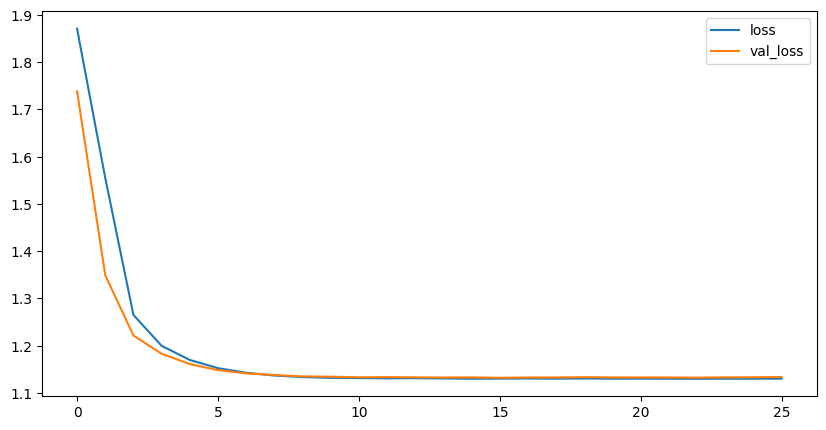

In [140]:
plot_loss_values(adapted_inception_model.history.history)

In [141]:
model_path_full

'/content/drive/MyDrive/Colab Notebooks/mineracao_dados_complexos/mdc/08_deep_learning/test01/artefatos/adapted_inception_model_finetunning.h5'

In [27]:
from tensorflow.keras.applications import InceptionResNetV2

In [26]:
loaded_adapted_inception_model = tf.keras.models.load_model(model_path_full,
                                                            )


ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [23]:
loaded_adapted_inception_model = tf.keras.models.load_model(model_path_full)

ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
print_accuracy_and_loss(
    adapted_inception_model,
    "adapted_inception_model_finetunning",
    "Modelo adapted_inception_model_finetunning",
    "validation")